# **3-1) Auto-Encoders for Classification**

In [82]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import math

from torchvision import datasets
from torchvision import transforms
from kmeans_pytorch import kmeans, kmeans_predict
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.metrics.cluster import adjusted_rand_score

In [83]:
tensor_transform = transforms.ToTensor()
 
dataset = datasets.MNIST(root = "./data", train = True,
   download = True, transform = tensor_transform)
 
loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 64, shuffle = True)

In [84]:
xy_train = torchvision.datasets.MNIST( root="~/Handwritten_Deep_L/", train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), )
xy_test = torchvision.datasets.MNIST( root="~/Handwritten_Deep_L/", train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), )

In [85]:
xy_train, xy_validation = random_split(xy_train, [50000, 10000])

In [86]:
x_train = list(zip(*xy_train))[0]
y_train = list(zip(*xy_train))[1]

x_validation = list(zip(*xy_validation))[0]
y_validation = list(zip(*xy_validation))[1]

x_test = xy_test.data / 255
y_test = xy_test.targets

In [87]:
x_train = [t.reshape (1, 784) for t in x_train]
x_train = [t.numpy() for t in x_train]
x_train = torch.tensor(x_train)

x_validation = [t.reshape (1, 784) for t in x_validation]
x_validation = [t.numpy() for t in x_validation]
x_validation = torch.tensor(x_validation)

x_test = x_test.reshape (10000, 1, 784)


In [88]:
y_train = torch.tensor(y_train)
y_validation = torch.tensor(y_validation)
y_test = torch.tensor(y_test)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13796\3824545513.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)


## **a)**

In [89]:
class auto_encoder(torch.nn.Module):

    def __init__(self):
        
        super(auto_encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 512),
            torch.nn.Tanh(),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.Tanh(),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 10)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 512),
            torch.nn.Tanh(),
            torch.nn.Linear(512, 784),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        self.encoded = self.encoder(x)
        decoded = self.decoder(self.encoded)
        return self.encoded, decoded

In [90]:
# We move our tensor to the GPU if available
if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE)

cuda


## **b)**

In [91]:
def fit(model, X_train, optimizer,  loss_function):

    train_running_loss = 0
    model.train()   # Training mode (allow weight updates)
    model = model.to(DEVICE)
    for image in X_train:
        image = image.to(DEVICE)
        # Output of Autoencoder
        encoded, reconstructed = model(image)
        # inputs: input, target
        loss = loss_function(reconstructed, image)
        train_running_loss += loss.item()
        # The gradients are set to zero,
        optimizer.zero_grad()
        # the gradient is computed and stored.
        loss.backward()
        # .step() performs parameter update
        optimizer.step()
    train_running_loss = train_running_loss/len(X_train)
    
    return model, train_running_loss, reconstructed

In [92]:
def validation(model, X_validation,  loss_function):

    val_running_loss = 0

    for image in X_validation:
      image = image.to(DEVICE)
      # Output of Autoencoder
      encoded, reconstructed = model(image)
      # Calculating the loss function
      loss = loss_function(reconstructed, image)
      val_running_loss += loss.item()
      # ## No backprop here (because we are validating)
    val_running_loss = val_running_loss/len(X_validation)
    
    return val_running_loss

In [93]:
def train (epochs, X_train, X_validation, model, loss_function, wLoss, optimizer):
   outputs = []
   train_loss = []
   val_loss = []

   model = model.to(DEVICE)
   wLoss = torch.tensor(wLoss)
   wLoss = wLoss.to(DEVICE)

   for epoch in range(epochs):
      train_running_loss = 0
      val_running_loss = 0
      print("epoch " + str(epoch + 1) + " of " + str(epochs) + ":")
      start = time.time()
      # training
      for image in X_train:
         image = image.to(DEVICE)
         # Output of Autoencoder
         encoded, reconstructedT = model(image)
         # inputs: input, target
         loss = loss_function(reconstructedT, image, wLoss)
         train_running_loss += loss.item()
         # The gradients are set to zero,
         optimizer.zero_grad()
         # the gradient is computed and stored.
         loss.backward()
         # .step() performs parameter update
         optimizer.step()
      train_running_loss = train_running_loss/len(X_train)
      # validation
      for image in X_validation:
         image = image.to(DEVICE)
         # Output of Autoencoder
         encoded, reconstructedV = model(image)
         # Calculating the loss function
         loss = loss_function(reconstructedV, image, wLoss)
         val_running_loss += loss.item()
         # ## No backprop here (because we are validating)
      val_running_loss = val_running_loss/len(X_validation)

      train_loss.append(train_running_loss)
      val_loss.append(val_running_loss)
      end = time.time()

      print(f"Training time: {(end-start)/60:.3f} minutes")
      print(f"Train Loss: {train_running_loss:.4f}, Validation Loss: {val_running_loss:.4f}.")

   return model, train_loss, val_loss

In [94]:
m = 1000
xy_mSamples, _ = random_split(xy_train, [m, 50000-m])

x_mSamples = list(zip(*xy_mSamples))[0]
y_mSamples = list(zip(*xy_mSamples))[1]

x_mSamples = [t.reshape (1, 784) for t in x_mSamples]
x_mSamples = [t.numpy() for t in x_mSamples]
x_mSamples = torch.tensor(x_mSamples)

y_mSamples = torch.tensor(y_mSamples)

wLoss = [0] * 784
for i in range (28*28):
    w1 = 0
    w2 = 0
    c1 = 0
    c2 = 0
    cmp = (y_mSamples == y_mSamples[i])
    for j in range (1, m):
        if cmp[j] == 1:
            w1 += math.exp(-(((x_mSamples[j-1][0][i]-x_mSamples[j][0][i])))**2)
            c1 += 1
        else:
            w2 += (1-math.exp(-(x_mSamples[j-1][0][i]-x_mSamples[j][0][i])**2))
            c2 += 1
    wLoss[i] = w1/c1 * w2/c2

In [95]:
class weighted_MSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return ((((inputs - targets)**2) * weights).mean(dim = 2)).mean(dim = (0, 1))

In [96]:
model = auto_encoder()
loss_function = weighted_MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-8)
x_trainLoader = DataLoader(x_train, batch_size=100, shuffle=True)
x_validationLoader = DataLoader(x_validation, batch_size=100, shuffle=True)
model, train_loss, val_loss = train(200, x_trainLoader, x_validationLoader, model, loss_function, wLoss, optimizer)

epoch 1 of 200:
Training time: 0.032 minutes
Train Loss: 0.0078, Validation Loss: 0.0056.
epoch 2 of 200:
Training time: 0.028 minutes
Train Loss: 0.0047, Validation Loss: 0.0041.
epoch 3 of 200:
Training time: 0.029 minutes
Train Loss: 0.0039, Validation Loss: 0.0036.
epoch 4 of 200:
Training time: 0.028 minutes
Train Loss: 0.0034, Validation Loss: 0.0034.
epoch 5 of 200:
Training time: 0.027 minutes
Train Loss: 0.0032, Validation Loss: 0.0031.
epoch 6 of 200:
Training time: 0.027 minutes
Train Loss: 0.0030, Validation Loss: 0.0030.
epoch 7 of 200:
Training time: 0.027 minutes
Train Loss: 0.0029, Validation Loss: 0.0028.
epoch 8 of 200:
Training time: 0.027 minutes
Train Loss: 0.0028, Validation Loss: 0.0028.
epoch 9 of 200:
Training time: 0.028 minutes
Train Loss: 0.0027, Validation Loss: 0.0027.
epoch 10 of 200:
Training time: 0.028 minutes
Train Loss: 0.0026, Validation Loss: 0.0027.
epoch 11 of 200:
Training time: 0.026 minutes
Train Loss: 0.0026, Validation Loss: 0.0026.
epoch 12

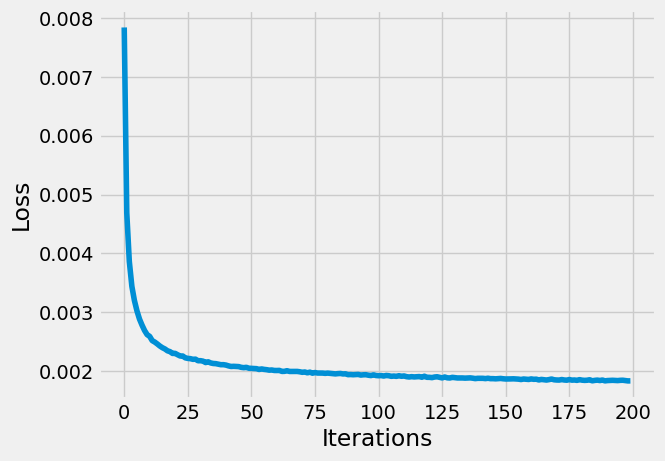

In [97]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_loss[-200:])

In [98]:
x_test = x_test.to(DEVICE)
_, reconstructedTst = model.forward(x_test)

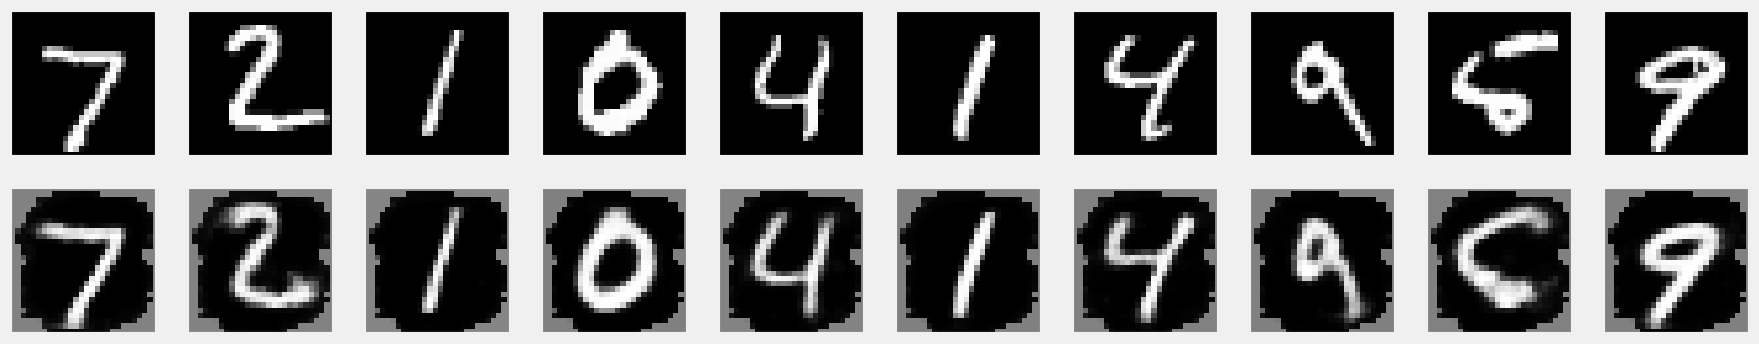

In [99]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original data
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].cpu().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructedTst[i].cpu().reshape(28, 28).data)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **c)**

In [104]:
x_train = x_train[:]
x_validation = x_validation[:]

x_train = x_train.to(DEVICE)
x_validation = x_validation.to(DEVICE)

x_trainEn, _ = model.forward(x_train)
x_validationEn, _ = model.forward(x_validation)
x_testEn, _ = model.forward(x_test)

In [105]:
cluster_ids_x, cluster_centers = kmeans(X=x_trainEn, num_clusters=10, distance='euclidean', device=torch.device(DEVICE))

running k-means on cuda..


[running kmeans]: 39it [00:00, 60.01it/s, center_shift=0.000037, iteration=39, tol=0.000100]


In [106]:
validation_results = kmeans_predict(x_validationEn, cluster_centers, 'euclidean', device=torch.device(DEVICE))
test_results = kmeans_predict(x_testEn, cluster_centers, 'euclidean', device=torch.device(DEVICE))

predicting on cuda..
predicting on cuda..


In [107]:
print("Train set ARI:")
print(adjusted_rand_score(y_train, cluster_ids_x))
print()

print("Validation set ARI:")
print(adjusted_rand_score(y_validation, validation_results))
print()

print("Test set ARI:")
print(adjusted_rand_score(y_test, test_results))

Train set ARI:
0.6137754131568322

Validation set ARI:
0.612982573578293

Test set ARI:
0.6184169705956812


: 